# Modelization


### Importing libraries

In [114]:
import pandas as pd
pd.set_option("max_columns", 50)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import tree
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from collections import OrderedDict, defaultdict
from sklearn.externals import joblib
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### Convenience functions
* Chart Results: Compares target with predicted data:

In [2]:
def chartResults(y, predBest, trainTest, model=None):
    
    '''
    Example of use
    chartResults(y=y_train, predBest=predTrain, trainTest='Train', model='Decision Trees')
    '''
    
    plt.figure(figsize=(6, 4))
    plt.scatter(y, predBest, s=20,alpha=0.1)
    plt.title(model + '\nPredicted Price vs. Real Price. \n' + trainTest + ' dataset')
    plt.xlabel('Real Price')
    plt.ylabel('Predicted Price')
    plt.plot([min(y), max(y)], [min(y), max(y)], 'y')
    
#    return plt.tight_layout()
    return plt.show()

def histResults(trainPred, testPred):
    
    '''
    Example of use
    histResults(trainPred=predKNNTrain, testPred=predKNNTest)
    '''
    
    _, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(trainPred, bins=40)
    axes[0].set_title('Train data')
    axes[1].hist(testPred, bins=40)
    axes[1].set_title('Test data')
    
    return plt.show()

* Results data frame:

In [119]:
modelizationResults = pd.DataFrame({'Algorithm': [], 
                                    'Fine_Tuning': [],
                                    'R2_Train': [], 
                                    'R2_Test': [], 
                                    'MAE_Train': [], 
                                    'MAE_Test': []})
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test


In [120]:
def rowOfResults(Algorithm, Fine_Tuning, R2_Train, R2_Test, MAE_Train, MAE_Test):
    '''
    Example:
    rowOfResults('Decision trees', True, 2, 3, 4, 5)
    '''
    tempResults = pd.DataFrame({'Algorithm': [Algorithm], 
                                'Fine_Tuning': [Fine_Tuning],
                                'R2_Train': [np.round(R2_Train, 3)],
                                'R2_Test': [np.round(R2_Test, 3)],
                                'MAE_Train': [np.round(MAE_Train, 0)],
                                'MAE_Test': [np.round(MAE_Test, 0)]})
    return tempResults

### Reading clean dataset


In [5]:
datasetCarsFinal = pd.read_csv('../data/autosFinal.csv',
                               usecols=[
                                      #'brand', 
                                      #'model', 
                                      'brandModel',
                                      'vehicleType', 
                                      'gearbox', 
                                      'yearOfRegistration',
                                      'fuelType',
                                      'powerPS',
                                      'kilometer',
                                      #'kilometerCategorical',
                                      #'kilometer000',
                                      'notRepairedDamage',
                                      #'postalCode',
                                      'state',
                                      'price'
                                      ],
                               dtype={
                                      #'brand': 'str', 
                                      #'model': 'str', 
                                      'brandModel': 'str', 
                                      'vehicleType': 'str', 
                                      'gearbox': 'str', 
                                      'yearOfRegistration': np.int64,
                                      'fuelType': 'str',
                                      'powerPS': np.int64,
                                      'kilometer': np.int64,
                                      #'kilometerCategorical': 'str',
                                      #'kilometer000': np.int64,
                                      'notRepairedDamage': 'str',
                                      #'postalCode': 'str',
                                      'state': 'str',
                                      'price': np.int64
                                      })

In [6]:
datasetCarsFinal.columns

Index(['state', 'brandModel', 'vehicleType', 'gearbox', 'fuelType',
       'notRepairedDamage', 'kilometer', 'powerPS', 'yearOfRegistration',
       'price'],
      dtype='object')

In [7]:
datasetCarsFinal.head()

,state,brandModel,vehicleType,gearbox,fuelType,notRepairedDamage,kilometer,powerPS,yearOfRegistration,price
0,Bayern,jeep grand,suv,automatik,diesel,nein,125000,163,2004,9800
1,Bayern,volkswagen golf,kleinwagen,manuell,benzin,nein,150000,75,2001,1500
2,Hessen,skoda fabia,kleinwagen,manuell,diesel,nein,90000,69,2008,3600
3,Nordrhein-Westfalen,bmw 3er,limousine,manuell,benzin,ja,150000,102,1995,650
4,Rheinland-Pfalz,peugeot 2_reihe,cabrio,manuell,benzin,nein,150000,109,2004,2200


***

## Data setup
### Splitting dataset into target, and numerical and categorical predictors
This is necessary in order to use LabelEncoder only on categorical features

In [8]:
target = datasetCarsFinal['price']
numerical = datasetCarsFinal[['yearOfRegistration', 'powerPS', 'kilometer']]
categorical = datasetCarsFinal.drop(['yearOfRegistration', 'powerPS', 'price', 'kilometer'], axis=1)

Now, we can apply Label encoder to each categorical column and rejoin columns in a new data frame

In [9]:
d = defaultdict(LabelEncoder)
categorical_encoded = categorical.apply(lambda x: d[x.name].fit_transform(x))
datasetCarsFinalConcat = pd.concat([categorical_encoded, numerical], axis=1)

For later use, we will save label encoding using joblib

In [10]:
joblib.dump(d, '../output/carsLabelEncoder.pkl')

['../output/carsLabelEncoder.pkl']

### Create train and test datasets

In [11]:
np.random.seed(42)
train, test = train_test_split(datasetCarsFinalConcat.index, test_size = 0.2)

X_train = datasetCarsFinalConcat.loc[train]
y_train = target.loc[train]

X_test = datasetCarsFinalConcat.loc[test]
y_test = target.loc[test]

In [12]:
X_train.shape, y_train.shape 

((202055, 9), (202055,))

In [13]:
X_test.shape, y_test.shape

((50514, 9), (50514,))

Now, data is ready to modelization process

***

## Decision Trees
Our first try will be Decision Trees algorithm. No hyperparameters will be tuned for the moment:

In [14]:
regrDT = tree.DecisionTreeRegressor().fit(X_train, y_train)

In [15]:
predDTTrain = regrDT.predict(X_train)
predDTTest = regrDT.predict(X_test)

### Distribution of predicted prices

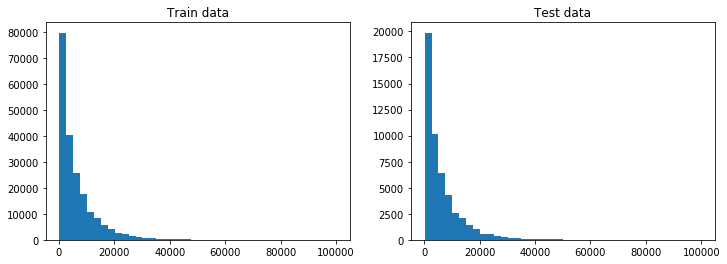

In [16]:
histResults(predDTTrain, predDTTest)

### Model scores:  
* $R^2$ Score:

In [121]:
R2DTTrain = r2_score(y_train, predDTTrain)
R2DTTest = r2_score(y_test, predDTTest)
print('R2 Train: %.3f' % R2DTTrain, '\nR2 Test:  %.3f' % R2DTTest)

R2 Train: 0.990 
R2 Test:  0.840


* MAE Score:

In [122]:
MAEDTTrain = mean_absolute_error(y_train, predDTTrain)
MAEDTTest = mean_absolute_error(y_test, predDTTest)
print('MAE Train:', format(MAEDTTrain, ',f'), '\nMAE Test:', format(MAEDTTest, ',f'))

MAE Train: 268.889971 
MAE Test: 1,306.618315


In [123]:
DTResults = rowOfResults('Decision trees', False, R2DTTrain, R2DTTest, MAEDTTrain, MAEDTTest)
DTResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,False,0.99,0.84,269.0,1307.0


In [124]:
modelizationResults = modelizationResults.append(DTResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.99,0.84,269.0,1307.0


Almost perfect with train data, but low $R²$ in test

Not bad results, but maybe some signals of overfitting. Let's go to some fine tuning on hyperparameters and cross validation to improve results.  
### Hyperparameter tuning

In [21]:
paramGridDT = {
        'criterion': ['mse'],
        'splitter': ['best', 'random'],
        'max_depth': list(range(1, 20 + 1)),
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [1],
        'max_features': ['auto']
        }

**ATTENTION**: With this paramGrid cross validation takes 2 minutes to complete

In [22]:
cvDT = GridSearchCV(
        estimator = tree.DecisionTreeRegressor(),
        param_grid=paramGridDT,
        n_jobs=-1,
        cv=10,
        refit=False,
        verbose=1,
        return_train_score=True).fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 346 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 598 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done 948 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.8min finished


These are the best parameters:

In [23]:
cvDT.best_params_

{'criterion': 'mse',
 'max_depth': 19,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 15,
 'splitter': 'best'}

In [24]:
bestDecisionTree = tree.DecisionTreeRegressor(criterion=cvDT.best_params_['criterion'],
                                              max_depth=cvDT.best_params_['max_depth'],
                                              max_features=cvDT.best_params_['max_features'],
                                              min_samples_leaf=cvDT.best_params_['min_samples_leaf'],
                                              min_samples_split=cvDT.best_params_['min_samples_split'],
                                              splitter=cvDT.best_params_['splitter']).fit(X_train, y_train)

In [25]:
predBestDTTrain = bestDecisionTree.predict(X_train)
predBestDTTest = bestDecisionTree.predict(X_test)

### Distribution of predicted prices

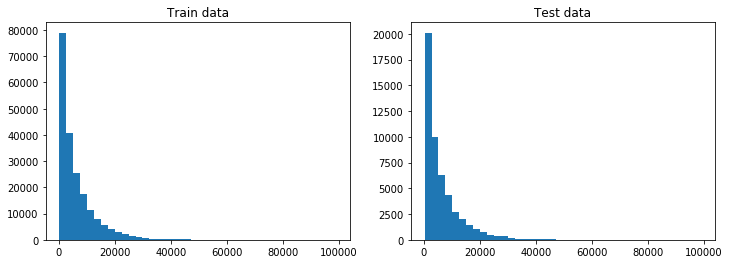

In [26]:
histResults(predBestDTTrain, predBestDTTest)

And the scores now are:

* $R^2$ Score:

In [125]:
R2BestDTTrain = r2_score(y_train, predBestDTTrain)
R2BestDTTest = r2_score(y_test, predBestDTTest)
print('R2 Train: %.3f' % R2BestDTTrain, '\nR2 Test: %.3f' % R2BestDTTest)

R2 Train: 0.943 
R2 Test: 0.875


* MAE Score:

In [126]:
MAEBestDTTrain = mean_absolute_error(y_train, predBestDTTrain)
MAEBestDTTest = mean_absolute_error(y_test, predBestDTTest)
print('MAE Train:', format(MAEBestDTTrain, ',f'), '\nMAE Test:', format(MAEBestDTTest, ',f'))

MAE Train: 938.492876 
MAE Test: 1,267.069267


In [127]:
DTBestResults = rowOfResults('Decision trees', True, R2BestDTTrain, R2BestDTTest, MAEBestDTTrain, MAEBestDTTest)
DTBestResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,True,0.943,0.875,938.0,1267.0


In [128]:
modelizationResults = modelizationResults.append(DTBestResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.990,0.840,269.0,1307.0
0,Decision trees,1.0,0.943,0.875,938.0,1267.0


We have improved test results but losing precision in test data.

## Charting results

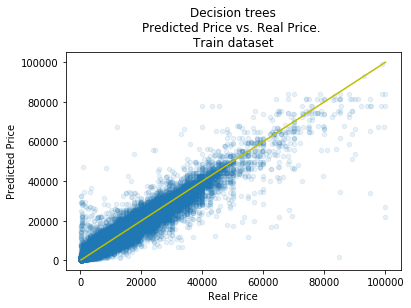

In [31]:
chartResults(y=y_train, predBest=predBestDTTrain, trainTest='Train', model='Decision trees')

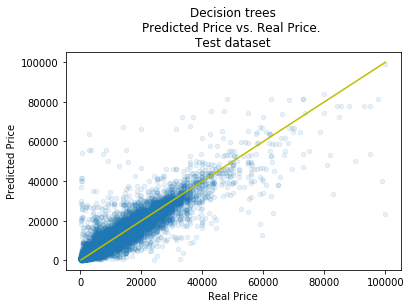

In [32]:
chartResults(y=y_test, predBest=predBestDTTest, trainTest='Test', model='Decision trees')

<BarContainer object of 9 artists>

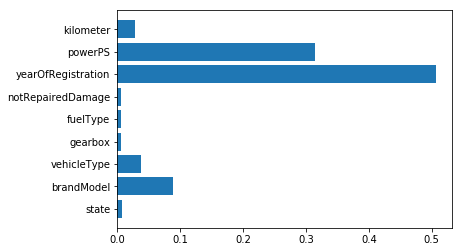

In [33]:
plt.barh(X_train.columns, bestDecisionTree.feature_importances_)

### Saving the model for later use

In [34]:
joblib.dump(bestDecisionTree, filename='../output/bestDecisionTree.pkl')

['../output/bestDecisionTree.pkl']

***

# Random forest
This will be the second algorithm we are going to use in order to improve results obtained with Decision Trees. Let's try to model without hyperparamenter tuning.

In [35]:
regrRF = RandomForestRegressor(n_jobs=-1,
                               verbose=1).fit(X_train,
                                              y_train)

[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.6s finished


In [36]:
predRFTrain = regrRF.predict(X_train)
predRFTest = regrRF.predict(X_test)

[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


### Distribution of predicted prices

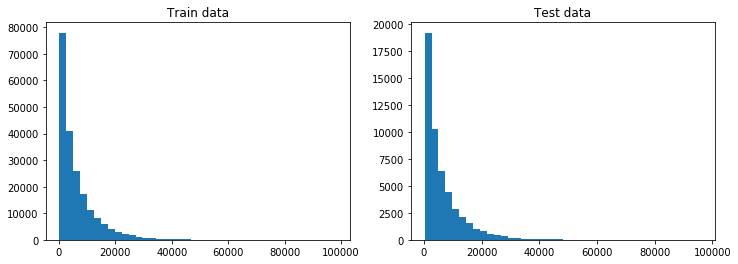

In [37]:
histResults(predRFTrain, predRFTest)

### Model scores:  
* $R^2$ Score:

In [129]:
R2RFTrain = r2_score(y_train, predRFTrain)
R2RFTest = r2_score(y_test, predRFTest)
print('R2 Train: %.3f' % R2RFTrain, '\nR2 Test:  %.3f' % R2RFTest)

R2 Train: 0.975 
R2 Test:  0.893


* MAE Score:

In [130]:
MAERFTrain = mean_absolute_error(y_train, predRFTrain)
MAERFTest = mean_absolute_error(y_test, predRFTest)
print('MAE Train:', format(MAERFTrain, ',f'), '\nMSE Test:', format(MAERFTest, ',f'))

MAE Train: 575.693907 
MSE Test: 1,154.143040


In [131]:
RFResults = rowOfResults('Random Forest', False, R2RFTrain, R2RFTest, MAERFTrain, MAERFTest)
RFResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Random Forest,False,0.975,0.893,576.0,1154.0


In [132]:
modelizationResults = modelizationResults.append(RFResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.990,0.840,269.0,1307.0
0,Decision trees,1.0,0.943,0.875,938.0,1267.0
0,Random Forest,0.0,0.975,0.893,576.0,1154.0


### Hyperparameter tuning
Test the optimum number of features

In [42]:
np.random.seed(123)
scores = {}

rf = None

for max_features in [2,4,8, 'auto', None]:
    if rf is None:
        rf = RandomForestRegressor(n_estimators=50,
                                   max_features=max_features)
    else:
        rf.warm_start = False
        rf.max_features = max_features
    
    rf = rf.fit(X_train, y_train)
    scores[max_features] = rf.score(X_test, y_test)

4 is the best number of features to use in model

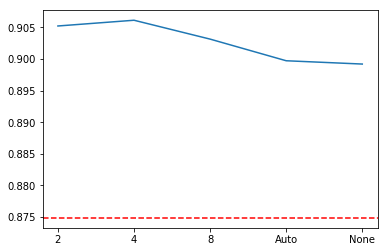

In [43]:
plt.plot([2, 4, 8, 'Auto', 'None'], scores.values())
plt.axhline(bestDecisionTree.score(X_test, y_test), linestyle='dashed', color='red')

In [44]:
paramsRF = {
        'n_estimators': [50, 100, 200],
        'max_features': [4],
        'max_depth': list(range(1, 10 + 1)),
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf':[1]
        }

This param grid takes 1 hours

In [45]:
cvRF = GridSearchCV(
        estimator=RandomForestRegressor(oob_score=True),
        param_grid=paramsRF,
        n_jobs=-1,
        cv=10,
        verbose=1,
        return_train_score=True).fit(X_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 41.0min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 51.7min finished


In [46]:
cvRF.best_params_

{'max_depth': 10,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [47]:
bestRandomForest = RandomForestRegressor(max_depth=cvRF.best_params_['max_depth'], 
                                        max_features=cvRF.best_params_['max_features'], 
                                        min_samples_leaf=cvRF.best_params_['min_samples_leaf'], 
                                        min_samples_split=cvRF.best_params_['min_samples_split'], 
                                        n_estimators=cvRF.best_params_['n_estimators']).fit(X_train, y_train)

In [48]:
predBestRFTrain = bestRandomForest.predict(X_train)
predBestRFTest = bestRandomForest.predict(X_test)

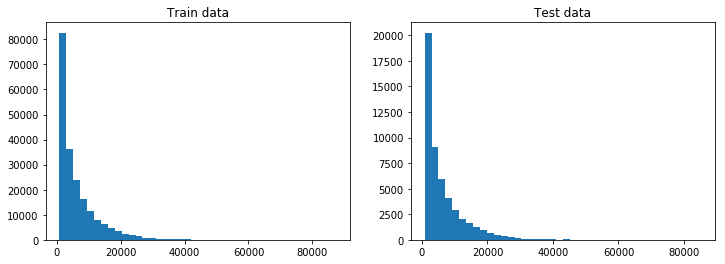

In [49]:
histResults(predBestRFTrain, predBestRFTest)

### Model scores:  
* $R^2$ Score:

In [133]:
R2BestRFTrain = r2_score(y_train, predBestRFTrain)
R2BestRFTest = r2_score(y_test, predBestRFTest)
print('R2 Train: %.3f' % R2BestRFTrain, '\nR2 Test: %.3f' % R2BestRFTest)

R2 Train: 0.897 
R2 Test: 0.878


* MAE Score:

In [134]:
MAEBestRFTrain = mean_absolute_error(y_train, predBestRFTrain)
MAEBestRFTest = mean_absolute_error(y_test, predBestRFTest)
print('MAE Train:', format(MAEBestRFTrain, ',f'), '\nMAE Test:', format(MAEBestRFTest, ',f'))

MAE Train: 1,362.776279 
MAE Test: 1,414.550980


In [135]:
RFBestResults = rowOfResults('Random Forest', True, R2BestRFTrain, R2BestRFTest, MAEBestRFTrain, MAEBestRFTest)
RFBestResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Random Forest,True,0.897,0.878,1363.0,1415.0


In [136]:
modelizationResults = modelizationResults.append(RFBestResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.990,0.840,269.0,1307.0
0,Decision trees,1.0,0.943,0.875,938.0,1267.0
0,Random Forest,0.0,0.975,0.893,576.0,1154.0
0,Random Forest,1.0,0.897,0.878,1363.0,1415.0


## Charting results

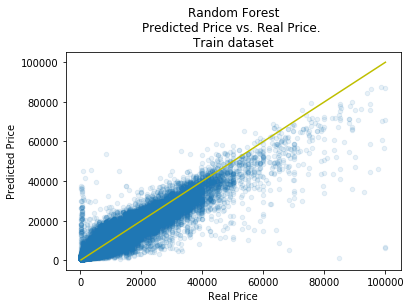

In [54]:
chartResults(y=y_train, predBest=predBestRFTrain, trainTest='Train', model='Random Forest')

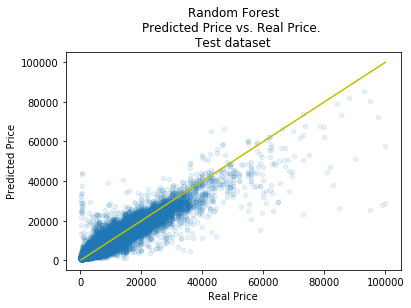

In [55]:
chartResults(y=y_test, predBest=predBestRFTest, trainTest='Test', model='Random Forest')

<BarContainer object of 9 artists>

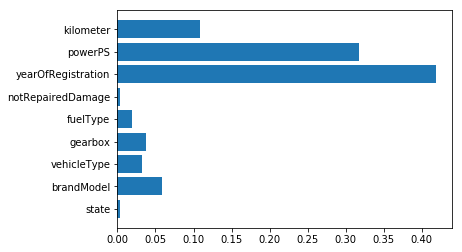

In [56]:
plt.barh(X_train.columns, bestRandomForest.feature_importances_)

### Saving the model for later use

In [57]:
joblib.dump(bestRandomForest, filename='../output/bestRandomForest.pkl')

['../output/bestRandomForest.pkl']

***

# K-nearest neighbours

First try, no hyperparameter tuning

In [58]:
regrKNN = neighbors.KNeighborsRegressor(n_jobs=-1).fit(X_train, y_train)

In [59]:
predKNNTrain = regrKNN.predict(X_train)
predKNNTest = regrKNN.predict(X_test)

### Distribution of predicted prices

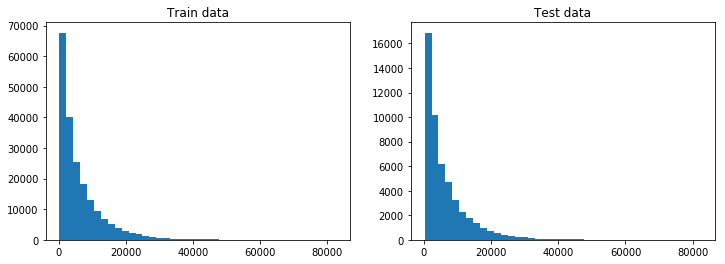

In [60]:
histResults(predKNNTrain, predKNNTest)

### Model score:  
* $R^2$ Score:

In [137]:
R2KNNTrain = r2_score(y_train, predKNNTrain)
R2KNNTest = r2_score(y_test, predKNNTest)
print('R2 Train: %.3f' % R2KNNTrain, '\nR2 Test:  %.3f' % R2KNNTest)

R2 Train: 0.900 
R2 Test:  0.837


* MAE Score:

In [138]:
MAEKNNTrain = mean_absolute_error(y_train, predKNNTrain)
MAEKNNTest = mean_absolute_error(y_test, predKNNTest)
print('MAE Train:', format(MAEKNNTrain, ',f'), '\nMAE Test:', format(MAEKNNTest, ',f'))

MAE Train: 1,137.888419 
MAE Test: 1,424.563685


In [139]:
KNNResults = rowOfResults('K-nearest neighbours', False, R2KNNTrain, R2KNNTest, MAEKNNTrain, MAEKNNTest)
KNNResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,K-nearest neighbours,False,0.9,0.837,1138.0,1425.0


In [140]:
modelizationResults = modelizationResults.append(KNNResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.990,0.840,269.0,1307.0
0,Decision trees,1.0,0.943,0.875,938.0,1267.0
0,Random Forest,0.0,0.975,0.893,576.0,1154.0
0,Random Forest,1.0,0.897,0.878,1363.0,1415.0
0,K-nearest neighbours,0.0,0.900,0.837,1138.0,1425.0


### Hyperparameter tuning

In [65]:
# Cross Validation
paramsKNN = {
        'n_neighbors': [5, 10, 20],
        'weights': ['distance', 'uniform'],
        'algorithm': ['auto'],
        'leaf_size': [2,3,4],
        }

This params grid takes 1 hour

In [66]:
cvKNN = GridSearchCV(
        estimator=neighbors.KNeighborsRegressor(),
        param_grid=paramsKNN,
        n_jobs=-1,
        cv=10,
        verbose=1,
        return_train_score=True).fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 41.1min finished


In [67]:
cvKNN.best_params_

{'algorithm': 'auto', 'leaf_size': 3, 'n_neighbors': 5, 'weights': 'distance'}

In [68]:
bestKNN = neighbors.KNeighborsRegressor(algorithm=cvKNN.best_params_['algorithm'], 
                                        leaf_size=cvKNN.best_params_['leaf_size'],
                                        n_neighbors=cvKNN.best_params_['n_neighbors'],
                                        weights=cvKNN.best_params_['weights']).fit(X_train, y_train)

In [69]:
predBestKNNTrain = bestKNN.predict(X_train)
predBestKNNTest = bestKNN.predict(X_test)

(array([  1.94950000e+04,   1.03550000e+04,   6.42900000e+03,
          4.44400000e+03,   2.70400000e+03,   2.13900000e+03,
          1.40700000e+03,   1.04400000e+03,   6.63000000e+02,
          5.09000000e+02,   3.77000000e+02,   2.86000000e+02,
          1.66000000e+02,   1.49000000e+02,   6.60000000e+01,
          6.80000000e+01,   5.20000000e+01,   3.10000000e+01,
          4.00000000e+01,   1.90000000e+01,   1.10000000e+01,
          1.30000000e+01,   9.00000000e+00,   5.00000000e+00,
          1.10000000e+01,   2.00000000e+00,   3.00000000e+00,
          3.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([   219. ,   2713.5,   5208. ,   7702.5,  10197. ,  12691.5,
         15186. ,  17680.5,  20175. ,  22669.5,  25164. ,  27658.5,
         30153. ,  32647.5,  3

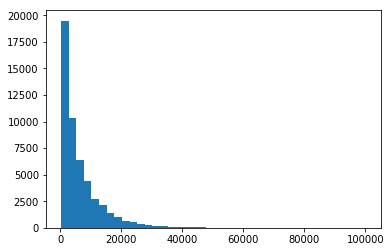

In [70]:
plt.hist(predBestKNNTest, bins=40)

### Model score:  
* $R^2$ Score:

In [141]:
R2BestKNNTrain = r2_score(y_train, predBestKNNTrain)
R2BestKNNTest = r2_score(y_test, predBestKNNTest)
print('R2 Train: %.3f' % R2BestKNNTrain, '\nR2 Test: %.3f' % R2BestKNNTest)

R2 Train: 0.990 
R2 Test: 0.850


* MAE Score:

In [142]:
MAEBestKNNTrain = mean_absolute_error(y_train, predBestKNNTrain)
MAEBestKNNTest = mean_absolute_error(y_test, predBestKNNTest)
print('MAE Train:', format(MAEBestKNNTrain, ',f'), '\nMAE Test:', format(MAEBestKNNTest, ',f'))

MAE Train: 272.409318 
MAE Test: 1,278.637815


In [143]:
KNNBestResults = rowOfResults('K-nearest neighbours', True, R2BestKNNTrain, R2BestKNNTest, MAEBestKNNTrain, MAEBestKNNTest)
KNNBestResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,K-nearest neighbours,True,0.99,0.85,272.0,1279.0


In [144]:
modelizationResults = modelizationResults.append(KNNBestResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.990,0.840,269.0,1307.0
0,Decision trees,1.0,0.943,0.875,938.0,1267.0
0,Random Forest,0.0,0.975,0.893,576.0,1154.0
0,Random Forest,1.0,0.897,0.878,1363.0,1415.0
0,K-nearest neighbours,0.0,0.900,0.837,1138.0,1425.0
0,K-nearest neighbours,1.0,0.990,0.850,272.0,1279.0


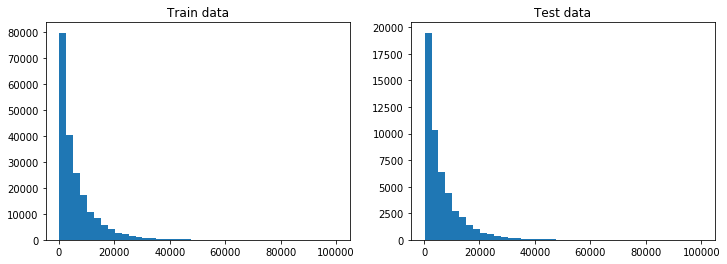

In [75]:
histResults(predBestKNNTrain, predBestKNNTest)

## Charting results
Train data

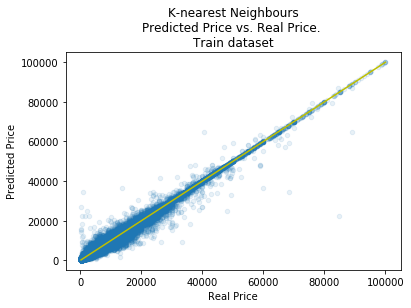

In [76]:
chartResults(y=y_train, predBest=predBestKNNTrain, trainTest='Train', model='K-nearest Neighbours')

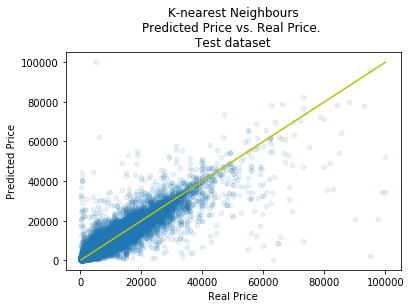

In [77]:
chartResults(y=y_test, predBest=predBestKNNTest, trainTest='Test', model='K-nearest Neighbours')

### Saving the model for later use

In [78]:
joblib.dump(bestKNN, filename='../output/bestKNN.pkl')

['../output/bestKNN.pkl']

***

# Gradient boosting

First try, no hyperparameters tuning

In [79]:
regrBoost = GradientBoostingRegressor().fit(X_train, y_train)

In [80]:
predBoostTrain = regrBoost.predict(X_train)
predBoostTest = regrBoost.predict(X_test)

### Distribution of predicted prices

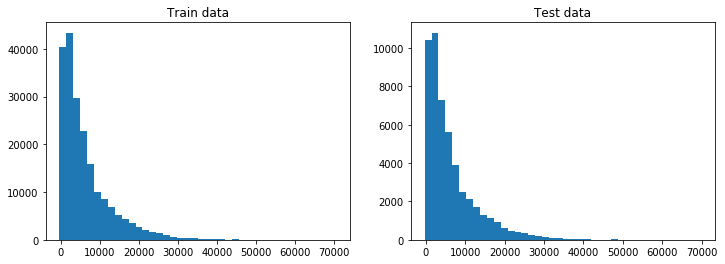

In [81]:
histResults(predBoostTrain, predBoostTest)

### Model score:  
* $R^2$ Score:

In [145]:
R2BoostTrain = r2_score(y_train, predBoostTrain)
R2BoostTest = r2_score(y_test, predBoostTest)
print('R2 Train: %.3f' % R2BoostTrain, '\nR2 Test:  %.3f' % R2BoostTest)

R2 Train: 0.847 
R2 Test:  0.847


* MAE Score:

In [146]:
MAEBoostTrain = mean_absolute_error(y_train, predBoostTrain)
MAEBoostTest = mean_absolute_error(y_test, predBoostTest)
print('MAE Train:', format(MAEBoostTrain, ',f'), '\nMAE Test:', format(MAEBoostTest, ',f'))

MAE Train: 1,520.402289 
MAE Test: 1,528.289220


In [147]:
BoostResults = rowOfResults('Gradient Boosting', False, R2BoostTrain, R2BoostTest, MAEBoostTrain, MAEBoostTest)
BoostResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Gradient Boosting,False,0.847,0.847,1520.0,1528.0


In [148]:
modelizationResults = modelizationResults.append(BoostResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.990,0.840,269.0,1307.0
0,Decision trees,1.0,0.943,0.875,938.0,1267.0
0,Random Forest,0.0,0.975,0.893,576.0,1154.0
0,Random Forest,1.0,0.897,0.878,1363.0,1415.0
0,K-nearest neighbours,0.0,0.900,0.837,1138.0,1425.0
0,K-nearest neighbours,1.0,0.990,0.850,272.0,1279.0
0,Gradient Boosting,0.0,0.847,0.847,1520.0,1528.0


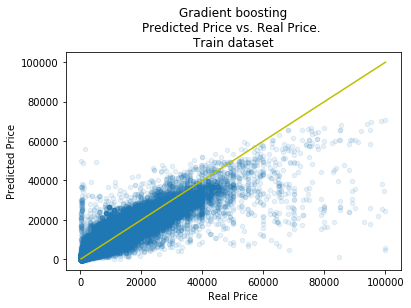

In [86]:
chartResults(y=y_train, predBest=predBoostTrain, trainTest='Train', model='Gradient boosting')

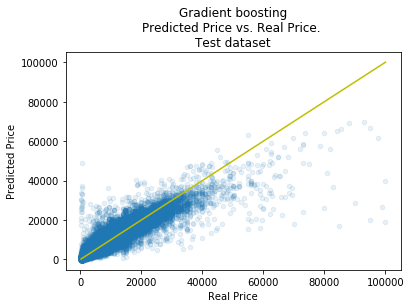

In [87]:
chartResults(y=y_test, predBest=predBoostTest, trainTest='Test', model='Gradient boosting')

### Hyperparameter tuning

**ATTENTION** This paramgrid takes 3 hours to complete

In [90]:
paramsBoost = {
        'learning_rate': [0.001, 0.01, 0.1],
        'n_estimators': [100, 200, 500],
        'max_depth': [1, 3, 5],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'max_features': [None, 'auto']
        }

In [91]:
cvBoost = GridSearchCV(
        estimator=GradientBoostingRegressor(),
        param_grid=paramsBoost,
        n_jobs=-1,
        cv=10,
        verbose=1,
        return_train_score=True).fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 119.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 165.1min finished


In [92]:
cvBoost.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [93]:
bestBoost = GradientBoostingRegressor(learning_rate=cvBoost.best_params_['learning_rate'],
                                      max_depth=cvBoost.best_params_['max_depth'],
                                      max_features=cvBoost.best_params_['max_features'],
                                      min_samples_leaf=cvBoost.best_params_['min_samples_leaf'],
                                      min_samples_split=cvBoost.best_params_['min_samples_split'],
                                      n_estimators=cvBoost.best_params_['n_estimators']).fit(X_train, y_train)

In [94]:
predBestBoostTrain = bestBoost.predict(X_train)
predBestBoostTest = bestBoost.predict(X_test)

* $R^2$ Score:

In [149]:
R2BestBoostTrain = r2_score(y_train, predBestBoostTrain)
R2BestBoostTest = r2_score(y_test, predBestBoostTest)
print('R2 Train: %.3f' % R2BestBoostTrain, '\nR2 Test: %.3f' % R2BestBoostTest)

R2 Train: 0.932 
R2 Test: 0.908


* MAE Score:

In [150]:
MAEBestBoostTrain = mean_absolute_error(y_train, predBestBoostTrain)
MAEBestBoostTest = mean_absolute_error(y_test, predBestBoostTest)
print('MAE Train:', format(MAEBestBoostTrain, ',f'), '\nMAE Test:', format(MAEBestBoostTest, ',f'))

MAE Train: 1,104.575121 
MAE Test: 1,175.264070


In [151]:
BoostBestResults = rowOfResults('Gradient Boosting', True, R2BestBoostTrain, R2BestBoostTest, MAEBestBoostTrain, MAEBestBoostTest)
BoostBestResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Gradient Boosting,True,0.932,0.908,1105.0,1175.0


In [152]:
modelizationResults = modelizationResults.append(BoostBestResults)
modelizationResults

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MAE_Train,MAE_Test
0,Decision trees,0.0,0.990,0.840,269.0,1307.0
0,Decision trees,1.0,0.943,0.875,938.0,1267.0
0,Random Forest,0.0,0.975,0.893,576.0,1154.0
0,Random Forest,1.0,0.897,0.878,1363.0,1415.0
0,K-nearest neighbours,0.0,0.900,0.837,1138.0,1425.0
0,K-nearest neighbours,1.0,0.990,0.850,272.0,1279.0
0,Gradient Boosting,0.0,0.847,0.847,1520.0,1528.0
0,Gradient Boosting,1.0,0.932,0.908,1105.0,1175.0


<BarContainer object of 9 artists>

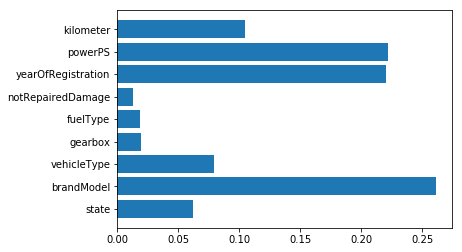

In [99]:
plt.barh(X_train.columns, bestBoost.feature_importances_)

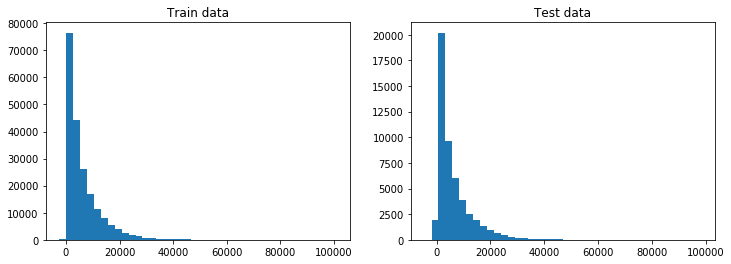

In [100]:
histResults(predBestBoostTrain, predBestBoostTest)

## Charting results

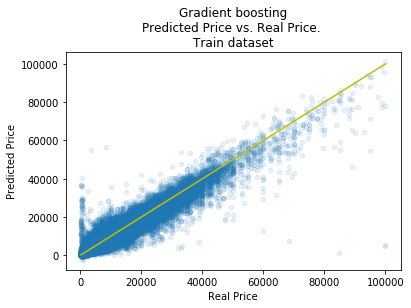

In [101]:
chartResults(y=y_train, predBest=predBestBoostTrain, trainTest='Train', model='Gradient boosting')

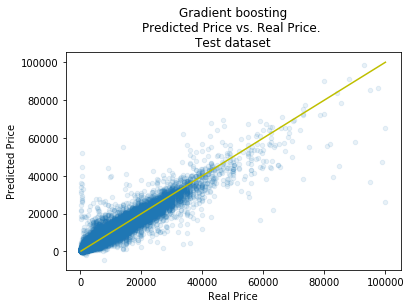

In [102]:
chartResults(y=y_test, predBest=predBestBoostTest, trainTest='Test', model='Gradient boosting')

### Saving the model for later use

In [104]:
joblib.dump(bestBoost, filename='../output/bestBoost.pkl')

['../output/bestBoost.pkl']

***

### Saving the results data frame

In [105]:
joblib.dump(modelizationResults, filename='../output/modelizationResults.pkl')
modelizationResults.to_csv(path_or_buf='../output/modelizationResults.csv')

# Testing things

In [106]:
bestDecisionTree = joblib.load('../output/bestDecisionTree.pkl')
bestRandomForest = joblib.load('../output/bestRandomForest.pkl')
bestKNN = joblib.load('../output/bestKNN.pkl')
bestBoost = joblib.load('../output/bestBoost.pkl')

(array([  4.07520000e+04,   7.15800000e+03,   1.87500000e+03,
          4.63000000e+02,   1.61000000e+02,   5.30000000e+01,
          2.90000000e+01,   1.50000000e+01,   7.00000000e+00,
          1.00000000e+00]),
 array([   299.66666667,  10169.7       ,  20039.73333333,  29909.76666667,
         39779.8       ,  49649.83333333,  59519.86666667,  69389.9       ,
         79259.93333333,  89129.96666667,  99000.        ]),
 <a list of 10 Patch objects>)

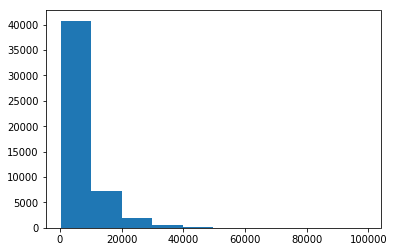

In [107]:
y_DT = bestDecisionTree.predict(X_test)
y_DT
plt.hist(y_DT)

(array([  2.02510000e+04,   9.07800000e+03,   5.96400000e+03,
          4.12700000e+03,   2.86700000e+03,   2.03600000e+03,
          1.64500000e+03,   1.22400000e+03,   9.42000000e+02,
          6.47000000e+02,   4.53000000e+02,   3.80000000e+02,
          2.54000000e+02,   1.77000000e+02,   9.00000000e+01,
          8.70000000e+01,   5.10000000e+01,   5.30000000e+01,
          4.40000000e+01,   2.90000000e+01,   3.20000000e+01,
          1.10000000e+01,   1.70000000e+01,   9.00000000e+00,
          7.00000000e+00,   6.00000000e+00,   4.00000000e+00,
          7.00000000e+00,   5.00000000e+00,   3.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([   822.78875515,   2934.59826583,   5046.40777651,   7158.21728718,
          9270.02679786,  11381.83630854,  13493.64581921,  15605.45532989,
         17717

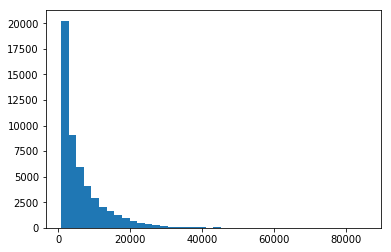

In [108]:
y_RF = bestRandomForest.predict(X_test)
y_RF
plt.hist(y_RF, bins=40)

(array([  1.94950000e+04,   1.03550000e+04,   6.42900000e+03,
          4.44400000e+03,   2.70400000e+03,   2.13900000e+03,
          1.40700000e+03,   1.04400000e+03,   6.63000000e+02,
          5.09000000e+02,   3.77000000e+02,   2.86000000e+02,
          1.66000000e+02,   1.49000000e+02,   6.60000000e+01,
          6.80000000e+01,   5.20000000e+01,   3.10000000e+01,
          4.00000000e+01,   1.90000000e+01,   1.10000000e+01,
          1.30000000e+01,   9.00000000e+00,   5.00000000e+00,
          1.10000000e+01,   2.00000000e+00,   3.00000000e+00,
          3.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   4.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          1.00000000e+00]),
 array([   219. ,   2713.5,   5208. ,   7702.5,  10197. ,  12691.5,
         15186. ,  17680.5,  20175. ,  22669.5,  25164. ,  27658.5,
         30153. ,  32647.5,  3

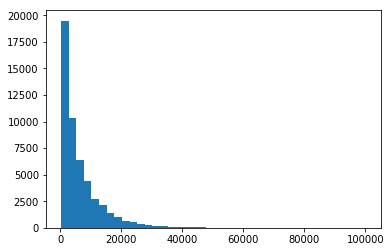

In [109]:
y_KNN = bestKNN.predict(X_test)
y_KNN
plt.hist(y_KNN, bins=40)

(array([  1.00000000e+00,   1.94200000e+03,   2.01930000e+04,
          9.64100000e+03,   6.03600000e+03,   3.92700000e+03,
          2.50400000e+03,   1.90800000e+03,   1.31000000e+03,
          9.24000000e+02,   6.24000000e+02,   4.25000000e+02,
          2.87000000e+02,   2.14000000e+02,   1.62000000e+02,
          9.80000000e+01,   6.50000000e+01,   5.60000000e+01,
          4.80000000e+01,   3.20000000e+01,   1.90000000e+01,
          1.80000000e+01,   1.40000000e+01,   1.80000000e+01,
          6.00000000e+00,   8.00000000e+00,   6.00000000e+00,
          9.00000000e+00,   5.00000000e+00,   4.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([ -4469.80939485,  -1897.80537496,    674.19864492,   3246.20266481,
          5818.2066847 ,   8390.21070458,  10962.21472447,  13534.21874436,
         16106

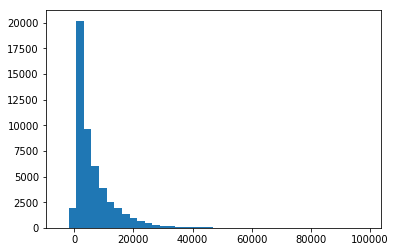

In [110]:
y_Boost = bestBoost.predict(X_test)
y_Boost
plt.hist(y_Boost, bins=40)

(array([  1.97440000e+04,   1.03430000e+04,   6.36700000e+03,
          4.37800000e+03,   2.53800000e+03,   2.18500000e+03,
          1.39800000e+03,   1.04600000e+03,   5.89000000e+02,
          5.42000000e+02,   3.62000000e+02,   3.02000000e+02,
          1.45000000e+02,   1.58000000e+02,   8.00000000e+01,
          8.70000000e+01,   4.20000000e+01,   3.90000000e+01,
          2.00000000e+01,   3.50000000e+01,   1.30000000e+01,
          1.20000000e+01,   1.40000000e+01,   1.70000000e+01,
          1.20000000e+01,   8.00000000e+00,   6.00000000e+00,
          7.00000000e+00,   1.00000000e+00,   6.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          3.00000000e+00]),
 array([   202.   ,   2696.925,   5191.85 ,   7686.775,  10181.7  ,
         12676.625,  15171.55 ,  17666.475,  20161.4  ,  22656.325,
         25151.25 ,  27646.175

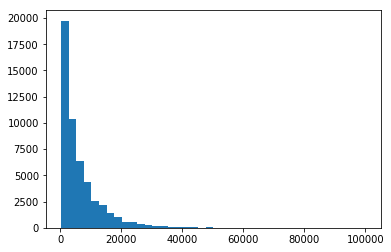

In [111]:
plt.hist(y_test, bins=40)

In [158]:
res = joblib.load('../output/modelizationResults.pkl')
res

,Algorithm,Fine_Tuning,R2_Train,R2_Test,MSE_Train,MSE_Test
0,Decision trees,0.0,0.990,0.840,534558.0,8498234.0
0,Decision trees,1.0,0.943,0.875,3057304.0,6666141.0
0,Random Forest,0.0,0.975,0.893,1324239.0,5705410.0
0,Random Forest,1.0,0.897,0.878,5515666.0,6525125.0
0,K-nearest neighbours,0.0,0.900,0.837,5339438.0,8683116.0
0,K-nearest neighbours,1.0,0.990,0.850,548192.0,7967688.0
0,Gradient Boosting,0.0,0.847,0.847,8178388.0,8139290.0
0,Gradient Boosting,1.0,0.932,0.908,3630293.0,4894695.0


In [113]:
boostPrices = pd.DataFrame({'Real prices': y_test,
                           'PredPrices': y_Boost})
boostPrices.head(20)

,Real prices,PredPrices
104366,2750,2795.556904
235879,595,893.683194
166299,4400,3240.455801
49392,10900,12510.585478
123067,700,1236.123223
210452,10900,11556.451351
114971,500,1746.421849
15393,10950,9498.455580
112543,1690,2758.787648
83674,7890,6108.674534
